#Preparation

In [58]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.patches import Rectangle

### Upload .csv

CSV Fields
*   SID --> Student ID,  eg. A123
*   Group --> eg. Full/ Slice
*   Scenario --> eg. Vulnerability types: Path/ DOS/ SQL/ XSS
*   DemoMX --> Demographic Metrics, eg. Skills in Java, programming experience
*   IntervMX --> Metric of your choice, eg. Number of correctly identified vulnerability
*   PercM --> Perceived metric, eg. Perceived ML accuracy, if not applicable to the experiment set value NULL

In [59]:
import pandas as pd

source_file_path = 'Copie de 2024 - TN - MYO Phishing_19 décembre 2024_20.34.xlsx'
destination_file_path = 'Classeur1.csv'


target_columns = [
    "Q7", "Q8_6", "Q468", "Q12", "Q17_10", "Q21", "Q26_10", "Q30", "Q35_10",
    "Q39", "Q43_10", "Q48", "Q53_10", "Q57", "Q62_10", "Q76", "Q81_10", "Q85",
    "Q90_10", "Q94", "Q99_10", "Q103", "Q107_10", "Q112", "Q117_10", "Q121",
    "Q126_10", "Q131_1"
]


source_file = pd.read_excel(source_file_path)

if 'Finished' in source_file.columns and 'Q3' in source_file.columns:
    filtered_file = source_file[
        (source_file['Finished'].str.lower() != 'false') & (source_file['Q3'].str.lower() != 'no')
    ]

    missing_columns = [col for col in target_columns if col not in filtered_file.columns]
    if not missing_columns:
        filtered_file = filtered_file[target_columns]
        filtered_file.dropna(inplace=True)
        filtered_file.to_csv(destination_file_path, index=False)



In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data
responses_file = 'Classeur1.csv'  # Replace with your file name
gt_file = 'gt.xlsx'  # Replace with your file name

# Load the response data and ground truth data
responses = pd.read_csv(responses_file)
gt_data = pd.read_excel(gt_file, sheet_name='Feuil1')

# Verify and extract relevant columns
email_type_columns = [
    col for col in responses.columns if 'What do you think of the email' in str(responses[col].iloc[0])
]
confidence_columns = [
    col for col in responses.columns if 'confidence level' in str(responses[col].iloc[0])
]
demographic_info = responses['Q468'].str.strip() if 'Q468' in responses.columns else None

if 'Q7' not in responses.columns:
    raise KeyError("The column 'Q7' is missing in the responses file.")

# Separate Responses by Group
group_a_responses = responses[responses['Q7'] == 'Treatment A']
group_b_responses = responses[responses['Q7'] == 'Treatment B']

# Ensure the extracted columns exist in both groups
group_a_email_type = group_a_responses[email_type_columns].applymap(
    lambda x: 1 if x == 'Phishing' else 0
)
group_b_email_type = group_b_responses[email_type_columns].applymap(
    lambda x: 1 if x == 'Phishing' else 0
)

# Function to Compare Responses with Ground Truth
def compare_responses(group_responses, gt_labels):
    comparison = group_responses.eq(gt_labels.values, axis=1)
    accuracy_first_half = comparison.iloc[:, :6].mean(axis=1).mean()
    accuracy_second_half = comparison.iloc[:, 6:].mean(axis=1).mean()

    fp_first_half = (
        (group_responses.iloc[:, :6] == 1) & (gt_labels.values[:6] == 0)
    ).sum(axis=1).mean()
    fp_second_half = (
        (group_responses.iloc[:, 6:] == 1) & (gt_labels.values[6:] == 0)
    ).sum(axis=1).mean()

    avg_difference_per_individual = (
        group_responses.iloc[:, 6:].mean(axis=1) - group_responses.iloc[:, :6].mean(axis=1)
    ).mean()

    return (
        accuracy_first_half,
        accuracy_second_half,
        fp_first_half,
        fp_second_half,
        avg_difference_per_individual,
    )

# Extract Ground Truth Labels
if len(gt_data.columns) >= 13:
    gt_labels = gt_data.iloc[0, 1:13].astype(int)
else:
    raise ValueError("The ground truth file does not contain enough columns.")

# Calculate Metrics for Each Group
results = {
    'Group': [],
    'Acc_First_Half': [],
    'Acc_Second_Half': [],
    'FP_First_Half': [],
    'FP_Second_Half': [],
}

# Process Group A
acc_first_a, acc_second_a, fp_first_a, fp_second_a, diff_a = compare_responses(
    group_a_email_type, gt_labels
)
results['Group'].append('A')
results['Acc_First_Half'].append(round(acc_first_a, 2))
results['Acc_Second_Half'].append(round(acc_second_a, 2))
results['FP_First_Half'].append(round(fp_first_a, 2))
results['FP_Second_Half'].append(round(fp_second_a, 2))

# Process Group B
acc_first_b, acc_second_b, fp_first_b, fp_second_b, diff_b = compare_responses(
    group_b_email_type, gt_labels
)
results['Group'].append('B')
results['Acc_First_Half'].append(round(acc_first_b, 2))
results['Acc_Second_Half'].append(round(acc_second_b, 2))
results['FP_First_Half'].append(round(fp_first_b, 2))
results['FP_Second_Half'].append(round(fp_second_b, 2))

# Display Results
results_df = pd.DataFrame(results)
print("\n=== Results by Group ===")
print(results_df)



=== Results by Group ===
  Group  Acc_First_Half  Acc_Second_Half  FP_First_Half  FP_Second_Half
0     A            0.29             0.25            2.0            2.25
1     B            0.70             0.70            1.2            1.40


<ipython-input-60-2f8a96a2cd79>:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  group_a_email_type = group_a_responses[email_type_columns].applymap(
<ipython-input-60-2f8a96a2cd79>:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  group_b_email_type = group_b_responses[email_type_columns].applymap(



Average Confidence Pre Training: 3.67
Average Confidence Post Training: 4.00


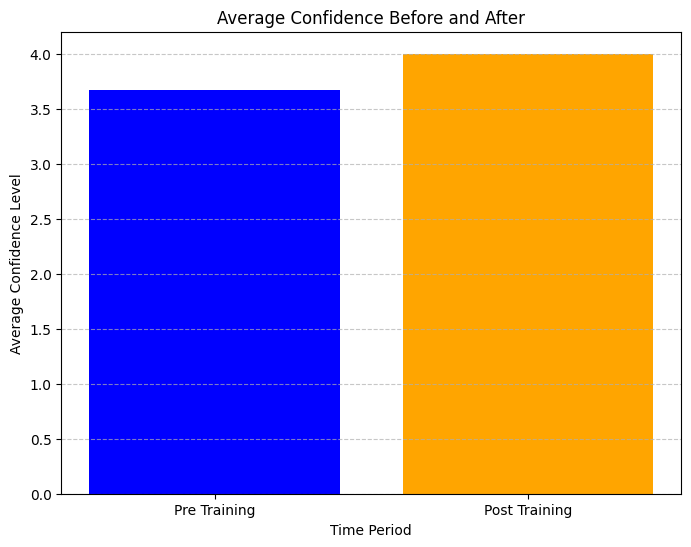

In [61]:
# Calculate Average Confidence PrePost
if {'Q8_6', 'Q131_1'}.issubset(responses.columns):
    responses[['Q8_6', 'Q131_1']] = responses[['Q8_6', 'Q131_1']].apply(pd.to_numeric, errors='coerce')
    avg_confidence_before = responses['Q8_6'].mean()
    avg_confidence_after = responses['Q131_1'].mean()
    print(f"\nAverage Confidence Pre Training: {avg_confidence_before:.2f}")
    print(f"Average Confidence Post Training: {avg_confidence_after:.2f}")

# Plot Average Confidence Before and After
    plt.figure(figsize=(8, 6))
    plt.bar(['Pre Training', 'Post Training'], [avg_confidence_before, avg_confidence_after], color=['blue', 'orange'])
    plt.title('Average Confidence Before and After')
    plt.xlabel('Time Period')
    plt.ylabel('Average Confidence Level')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


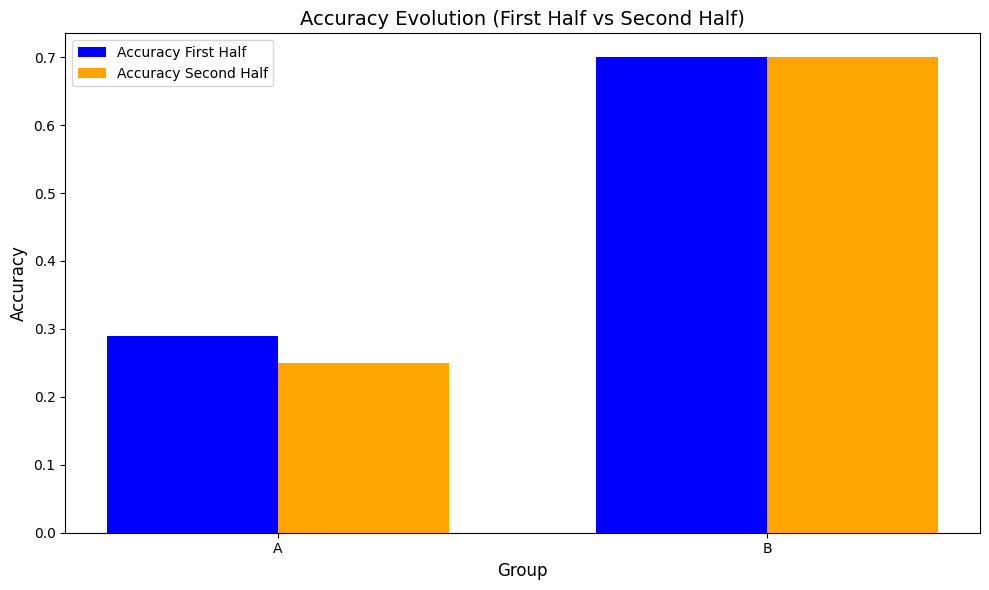

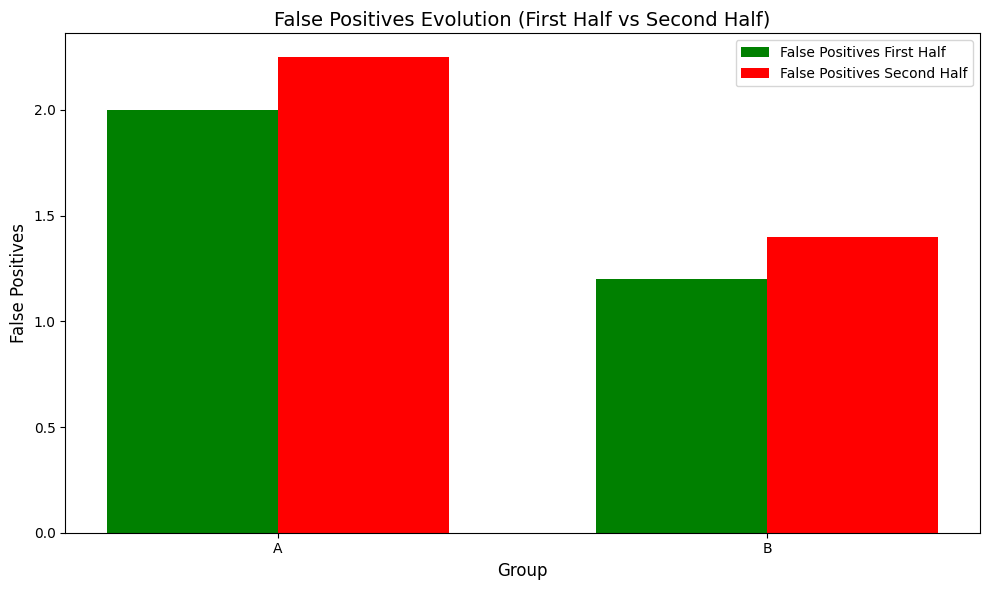

In [62]:
# Plot Accuracy: First Half vs Second Half
plt.figure(figsize=(10, 6))
bar_width = 0.35

# Positions of bars on the X-axis
r1 = np.arange(len(results_df['Group']))
r2 = [x + bar_width for x in r1]

# Create bar charts
plt.bar(
    r1, results_df['Acc_First_Half'], color='blue', width=bar_width, label='Accuracy First Half'
)
plt.bar(
    r2, results_df['Acc_Second_Half'], color='orange', width=bar_width, label='Accuracy Second Half'
)

plt.xlabel('Group', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Evolution (First Half vs Second Half)', fontsize=14)
plt.xticks(
    [r + bar_width / 2 for r in range(len(results_df['Group']))], results_df['Group'], fontsize=10
)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot False Positives: First Half vs Second Half
plt.figure(figsize=(10, 6))

# Create bar charts
plt.bar(
    r1, results_df['FP_First_Half'], color='green', width=bar_width, label='False Positives First Half'
)
plt.bar(
    r2, results_df['FP_Second_Half'], color='red', width=bar_width, label='False Positives Second Half'
)

plt.xlabel('Group', fontsize=12)
plt.ylabel('False Positives', fontsize=12)
plt.title('False Positives Evolution (First Half vs Second Half)', fontsize=14)
plt.xticks(
    [r + bar_width / 2 for r in range(len(results_df['Group']))], results_df['Group'], fontsize=10
)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()



Average Confidence Before: 3.67
Average Confidence After: 4.00


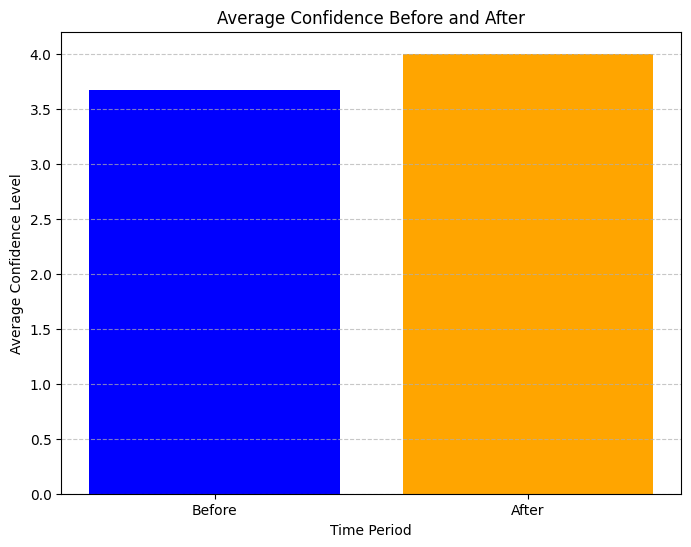

In [63]:
# Clean and Convert Confidence Columns
if {'Q8_6', 'Q131_1'}.issubset(responses.columns):
    responses['Q8_6'] = pd.to_numeric(responses['Q8_6'], errors='coerce')
    responses['Q131_1'] = pd.to_numeric(responses['Q131_1'], errors='coerce')

    # Calculate and Display Average Confidence Before and After
    avg_confidence_before = responses['Q8_6'].mean()
    avg_confidence_after = responses['Q131_1'].mean()
    print(f"\nAverage Confidence Before: {avg_confidence_before:.2f}")
    print(f"Average Confidence After: {avg_confidence_after:.2f}")

    # Plot Average Confidence Before and After
    plt.figure(figsize=(8, 6))
    plt.bar(['Before', 'After'], [avg_confidence_before, avg_confidence_after], color=['blue', 'orange'])
    plt.title('Average Confidence Before and After')
    plt.xlabel('Time Period')
    plt.ylabel('Average Confidence Level')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




=== Results by Group ===
  Group  Acc_First_Half  Acc_Second_Half  FP_First_Half  FP_Second_Half
0     A            0.29             0.25            2.0            2.25
1     B            0.70             0.70            1.2            1.40
Correlation between Pre-Training and Post-Training Accuracy: 1.00 (p-value: 1.0000)

=== Correlation Matrix ===
                   Acc_Pre_Training  Acc_Post_Training
Acc_Pre_Training                1.0                1.0
Acc_Post_Training               1.0                1.0


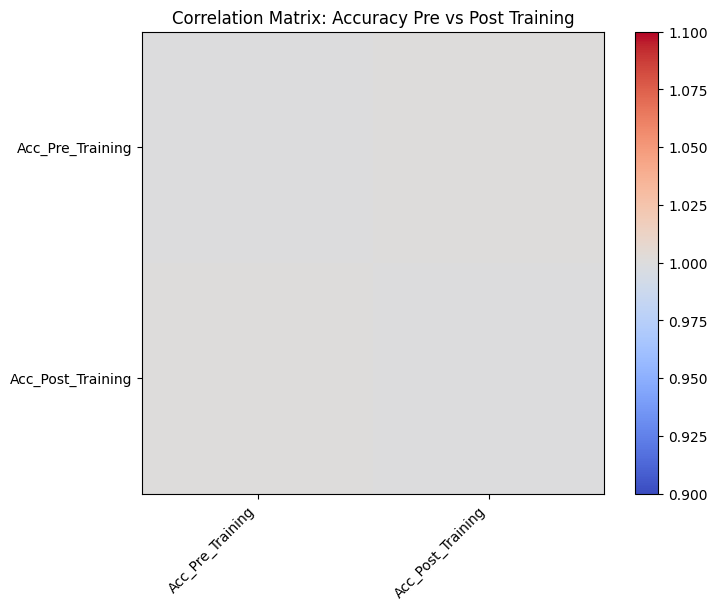

In [64]:
# Display Results
results_df = pd.DataFrame(results)
print("\n=== Results by Group ===")
print(results_df)

# Calculate Correlation Between Pre and Post Training Accuracy
accuracy_pre = results_df['Acc_First_Half']
accuracy_post = results_df['Acc_Second_Half']

# Pearson Correlation
correlation, p_value = pearsonr(accuracy_pre, accuracy_post)
print(f"Correlation between Pre-Training and Post-Training Accuracy: {correlation:.2f} (p-value: {p_value:.4f})")

# Correlation Matrix
correlation_matrix = pd.DataFrame({
    'Acc_Pre_Training': accuracy_pre,
    'Acc_Post_Training': accuracy_post
})

# Calculate and Display Correlation Matrix
corr_matrix = correlation_matrix.corr()
print("\n=== Correlation Matrix ===")
print(corr_matrix)

# Plot Heatmap of Correlation Matrix
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix: Accuracy Pre vs Post Training")
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], corr_matrix.columns, rotation=45, ha="right")
plt.yticks([0, 1], corr_matrix.index)
plt.show()